# Stage 02: Exploratory Data Analysis (Part 1)

## Basic Statistical Profiling

### Load Dataset

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer 

train_path = Path("../data/processed/pcl_task1_train.csv")
dev_path = Path("../data/processed/pcl_task1_dev.csv")

train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

print(train_df.shape, dev_df.shape)
train_df.head()

(8375, 7) (2094, 7)


,par_id,art_id,keyword,country_code,text,label_0to4,label_bin
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,0


### Token count

In [ ]:
train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split()))

print(train_df["word_count"].describe())
print("95th percentile:", np.percentile(train_df["word_count"], 95))

count    8375.000000
mean       48.675224
std        29.677952
min         1.000000
25%        30.000000
50%        42.000000
75%        60.000000
max       909.000000
Name: word_count, dtype: float64
95th percentile: 102.0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def count_tokens(text):
    return len(tokenizer.tokenize(text))

train_df["token_count"] = train_df["text"].apply(count_tokens)

print(train_df["token_count"].describe())
print("95th percentile:", np.percentile(train_df["token_count"], 95))

/Users/joshuakilla/Documents/PCL-detection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


count    8375.000000
mean       51.982328
std        31.707843
min         1.000000
25%        32.000000
50%        45.000000
75%        65.000000
max       954.000000
Name: token_count, dtype: float64
95th percentile: 110.0


### Vocabulary Size

In [5]:
vocab = set()
for text in train_df["text"]:
    tokens = tokenizer.tokenize(text)
    vocab.update(tokens)
print("Vocabulary size:", len(vocab))

Vocabulary size: 30790


### Class Distribution

In [ ]:
# Check for skew in label distribution between train and dev sets
print("Train:")
print(train_df["label_bin"].value_counts(normalize=True))

print("\nDev:")
print(dev_df["label_bin"].value_counts(normalize=True))

Train:
label_bin
0    0.905194
1    0.094806
Name: proportion, dtype: float64

Dev:
label_bin
0    0.904967
1    0.095033
Name: proportion, dtype: float64


In [7]:
# Check number of examples in each class and class ratios in the training set
print(f"Number of training samples: {len(train_df['label_bin'])}")
print(train_df["label_bin"].value_counts())

Number of training samples: 8375
label_bin
0    7581
1     794
Name: count, dtype: int64


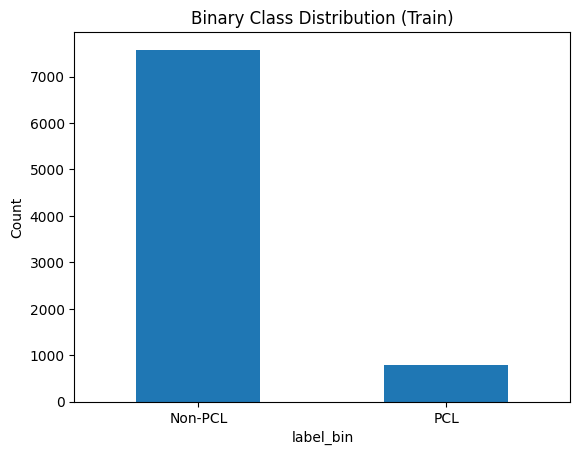

In [14]:
train_df["label_bin"].value_counts().plot(kind="bar")
plt.title("Binary Class Distribution (Train)")
plt.xticks([0,1], ["Non-PCL", "PCL"], rotation=0)
plt.ylabel("Count")
plt.show()

- way more non-PCL than PCL exmaples so could introduce weighted loss later so the objective isnt easily minimised by always predicting false (ie missing a positive penalises more)

In [8]:
# See how many clear/ambiguous PCL examples we have in the training set
print(train_df["label_0to4"].value_counts())
print(f"Level 0 PCL example ratio: {((train_df['label_0to4'] == 0).mean()):.5f}")
print(f"Level 1 PCL example ratio: {((train_df['label_0to4'] == 1).mean()):.5f}")
print(f"Level 2 PCL example ratio: {((train_df['label_0to4'] == 2).mean()):.5f}")
print(f"Level 3 PCL example ratio: {((train_df['label_0to4'] == 3).mean()):.5f}")
print(f"Level 4 PCL example ratio: {((train_df['label_0to4'] == 4).mean()):.5f}")

label_0to4
0    6825
1     756
3     369
4     299
2     126
Name: count, dtype: int64
Level 0 PCL example ratio: 0.81493
Level 1 PCL example ratio: 0.09027
Level 2 PCL example ratio: 0.01504
Level 3 PCL example ratio: 0.04406
Level 4 PCL example ratio: 0.03570


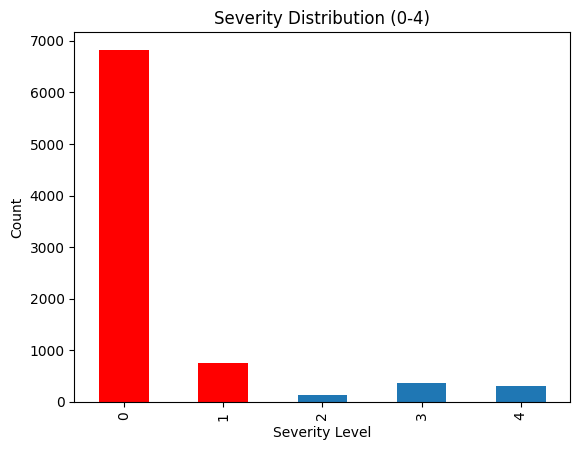

In [16]:
# Red is classed as non-PCL (0-1), blue is classed as PCL (2-4)
counts = train_df["label_0to4"].value_counts().sort_index()
colors = ['red' if i in [0, 1] else 'C0' for i in counts.index]
counts.plot(kind="bar", color=colors)
plt.title("Severity Distribution (0-4)")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()

In [50]:
# Check ratio of borderline positives against strong positives

print("Proportion of strong PCL & weak PCL in PCL examples:")
print("Weak PCL (2):", (train_df[train_df.label_bin == 1].label_0to4 == 2).mean())
print("Strong PCL (3-4):", ((train_df[train_df.label_bin == 1].label_0to4 >= 3)).mean())

Proportion of strong PCL & weak PCL in PCL examples:
Weak PCL (2): 0.15869017632241814
Strong PCL (3-4): 0.8413098236775819


In [9]:
# Check if PCL paragraphs are longer than non-PCL paragraphs
train_df.groupby("label_bin")["token_count"].describe()

,count,mean,std,min,25%,50%,75%,max
label_bin,,,,,,,,
0,7581.0,51.521171,31.272211,1.0,32.0,45.0,64.0,954.0
1,794.0,56.385390,35.319441,7.0,35.0,50.0,70.0,534.0


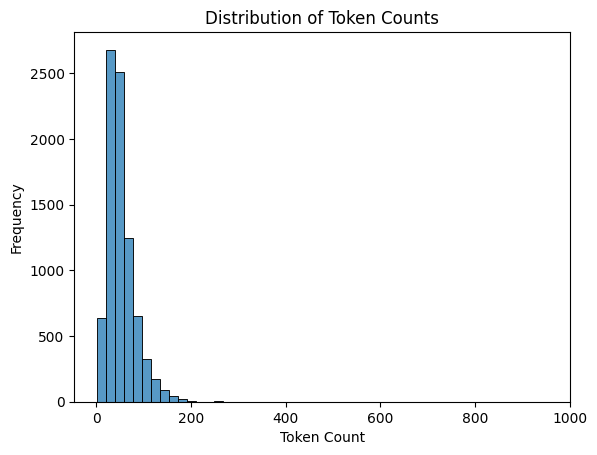

In [23]:
sns.histplot(data=train_df, x="token_count", bins=50)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Counts")
plt.show()

In [10]:
# Check if correlation betweens strength of PCL signal and paragraph length
train_df.groupby("label_0to4")["token_count"].describe()

,count,mean,std,min,25%,50%,75%,max
label_0to4,,,,,,,,
0,6825.0,51.063590,31.058293,1.0,32.00,44.0,63.00,954.0
1,756.0,55.652116,32.875231,3.0,34.00,48.0,69.25,434.0
2,126.0,52.277778,34.036836,7.0,33.25,45.5,63.75,261.0
3,369.0,54.539295,27.196531,7.0,36.00,49.0,70.00,158.0
4,299.0,60.394649,43.505898,7.0,34.00,53.0,74.00,534.0


Text(0.5, 1.0, 'Token Length by Class')

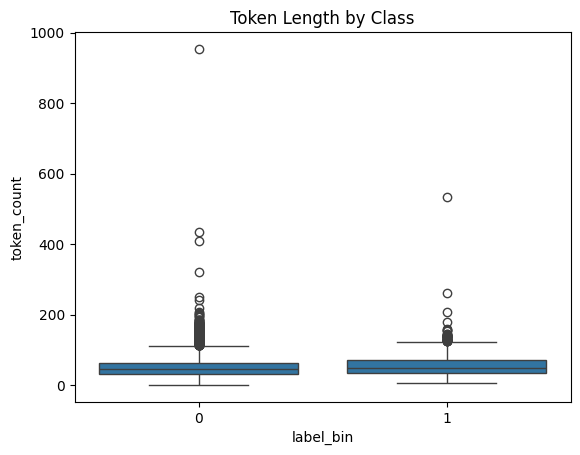

In [24]:
sns.boxplot(x="label_bin", y="token_count", data=train_df)
plt.title("Token Length by Class")

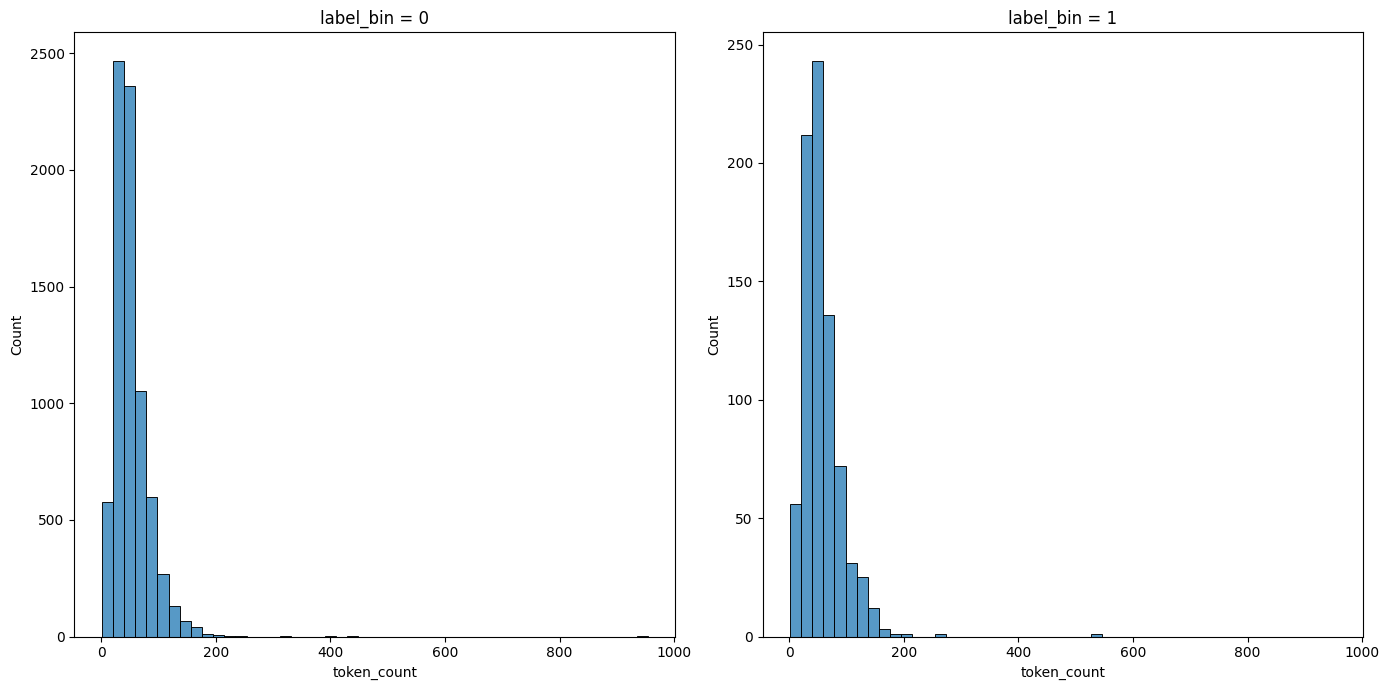

In [31]:
train_df["label_bin"] = train_df["label_bin"].astype(int)

df0 = train_df[train_df["label_bin"] == 0]
df1 = train_df[train_df["label_bin"] == 1]

bins = np.linspace(
    train_df["token_count"].min(),
    train_df["token_count"].max(),
    50
)

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True)

sns.histplot(data=df0, x="token_count", bins=bins, ax=axes[0])
axes[0].set_title("label_bin = 0")

sns.histplot(data=df1, x="token_count", bins=bins, ax=axes[1])
axes[1].set_title("label_bin = 1")

plt.tight_layout()
plt.show()

In [11]:
# Check if certain keywords are more common in PCL vs non-PCL paragraphs
pd.crosstab(train_df["keyword"], train_df["label_bin"], normalize="index")

label_bin,0,1
keyword,,
disabled,0.919664,0.080336
homeless,0.827746,0.172254
hopeless,0.875635,0.124365
immigrant,0.972716,0.027284
in-need,0.832944,0.167056
migrant,0.964853,0.035147
poor-families,0.844228,0.155772
refugee,0.917045,0.082955
vulnerable,0.931114,0.068886


In [12]:
# Check what proportion of positive and negative examples are made up of each keyword
pd.crosstab(train_df["keyword"],train_df["label_bin"],normalize="columns")

label_bin,0,1
keyword,,
disabled,0.101174,0.084383
homeless,0.094447,0.187657
hopeless,0.091017,0.123426
immigrant,0.108165,0.028967
in-need,0.094051,0.180101
migrant,0.112254,0.039043
poor-families,0.080069,0.141058
refugee,0.106450,0.091940
vulnerable,0.106978,0.075567


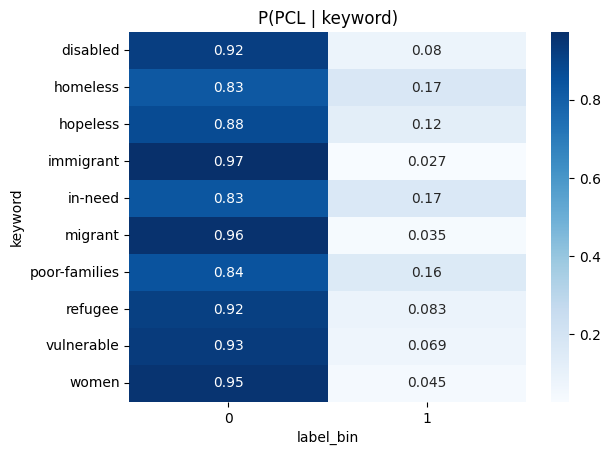

In [33]:

ct = pd.crosstab(train_df["keyword"], train_df["label_bin"], normalize="index")
sns.heatmap(ct, annot=True, cmap="Blues")
plt.title("P(PCL | keyword)")
plt.show()

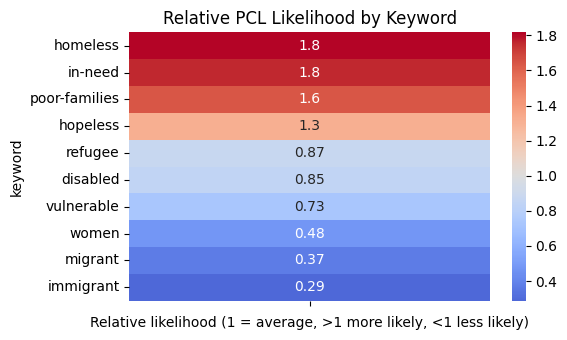

In [48]:
# Calaculte relative likelhood of PCL given keyword
# Also known as depdendency ratio (1 if neutral/indepdendent)

p_kw = pd.crosstab(train_df["keyword"], train_df["label_bin"], normalize="index")[1]

# baseline
p_base = train_df["label_bin"].mean()

# multipliers
score = (p_kw / (p_base + 1e-12)).sort_values(ascending=False)

# plot
plt.figure(figsize=(6, 0.35 * len(score)))
sns.heatmap(
    score.to_frame(""),
    annot=True,
    cmap="coolwarm",
    center=1
)

plt.title(f"Relative PCL Likelihood by Keyword")
plt.ylabel("keyword")
plt.xlabel("Relative likelihood (1 = average, >1 more likely, <1 less likely)")
plt.tight_layout()
plt.show()

 - Homlessness is 2x more likely to be PCL than the average PCL result and 6x more likely than immigrant 
 - Model should be fitted to tone to detect PCL not keywords like this 
      - By definition PCL depends more on how ppl are described not who is described
      - If a model is trained using this then it could cause topic based shortcuts
 - Should be used to check model bias